In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [73]:
import pyspark 
import shlex 
import datetime
import pandas as pd
from pandas import Series
from operator import add
from dateutil import parser
from datetime import timedelta
from collections import Counter
from pyspark.sql.window import Window
import numpy as np; np.random.seed(22)
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [4]:
sc = pyspark.SparkContext()

##### Reading the log file 

In [212]:
rdd_file = sc.textFile("WeblogChallenge/data/2015_07_22_mktplace_shop_web_log_sample.log.gz")

In [213]:
rdd_file.count()

1158500

In [214]:
rdd_file = sc.parallelize(rdd_file.take(100000))

## Processing & Analytical goals

##### a) Processing the log files 

In [215]:
def processLogs(x):
    """
    Takes in a line from the logs as inputs 
    and splits them into individual components 
    """
    keys = ['timestamp', 'elb',  'client:port',  'backend:port',  'request_processing_time',  \
            'backend_processing_time', 'response_processing_time', 'elb_status_code', 'backend_status_code', \
            'received_bytes', 'sent_bytes', 'request', 'user_agent', 'ssl_cipher', 'ssl_protocol']
    values = shlex.split(x)
    dict_ = dict({k:v for k, v in zip(keys, values)})
    return dict_

In [216]:
rdd_file = rdd_file.map(lambda x: processLogs(x))

In [217]:
rdd_file.take(1)

[{'backend:port': '10.0.6.158:80',
  'backend_processing_time': '0.026109',
  'backend_status_code': '200',
  'client:port': '123.242.248.130:54635',
  'elb': 'marketpalce-shop',
  'elb_status_code': '200',
  'received_bytes': '0',
  'request': 'GET https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null HTTP/1.1',
  'request_processing_time': '0.000022',
  'response_processing_time': '0.00002',
  'sent_bytes': '699',
  'ssl_cipher': 'ECDHE-RSA-AES128-GCM-SHA256',
  'ssl_protocol': 'TLSv1.2',
  'timestamp': '2015-07-22T09:00:28.019143Z',
  'user_agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.130 Safari/537.36'}]

##### b) Sessionalize the data with ip addess as the key 

In [218]:
rdd_file.map(lambda x:x['timestamp']).min(), rdd_file.map(lambda x:x['timestamp']).max()

('2015-07-22T09:00:23.610970Z', '2015-07-22T10:45:28.051374Z')

In [219]:
def makeTimeBuckets(mintime, maxtime, interval):
    buckets = []
    while mintime < maxtime:
        buckets.append((mintime, mintime + timedelta(minutes=interval)))
        mintime = mintime + timedelta(minutes=interval)
    return buckets

In [220]:
minTime = parser.parse(rdd_file.map(lambda x:x['timestamp']).min())
maxTime = parser.parse(rdd_file.map(lambda x:x['timestamp']).max())

In [221]:
buckets = makeTimeBuckets(mintime=minTime, maxtime=maxTime, interval=3)

In [222]:
len(buckets)

36

In [223]:
def getSessions(x, buckets=buckets):
    dt = parser.parse(x['timestamp'])
    for i in range(len(buckets)):
        if dt >= buckets[i][0] and dt <= buckets[i][1]:
            x['session'] = str(i) 
            break 
    return x

In [224]:
session_data = rdd_file.map(lambda x: getSessions(x))

In [225]:
session_data.take(1)

[{'backend:port': '10.0.6.158:80',
  'backend_processing_time': '0.026109',
  'backend_status_code': '200',
  'client:port': '123.242.248.130:54635',
  'elb': 'marketpalce-shop',
  'elb_status_code': '200',
  'received_bytes': '0',
  'request': 'GET https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null HTTP/1.1',
  'request_processing_time': '0.000022',
  'response_processing_time': '0.00002',
  'sent_bytes': '699',
  'session': '0',
  'ssl_cipher': 'ECDHE-RSA-AES128-GCM-SHA256',
  'ssl_protocol': 'TLSv1.2',
  'timestamp': '2015-07-22T09:00:28.019143Z',
  'user_agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.130 Safari/537.36'}]

In [226]:
session_data_client_session = session_data.map(lambda x:((x['client:port'], x['session']), x))

In [227]:
session_data_client_session.take(1)

[(('123.242.248.130:54635', '0'),
  {'backend:port': '10.0.6.158:80',
   'backend_processing_time': '0.026109',
   'backend_status_code': '200',
   'client:port': '123.242.248.130:54635',
   'elb': 'marketpalce-shop',
   'elb_status_code': '200',
   'received_bytes': '0',
   'request': 'GET https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null HTTP/1.1',
   'request_processing_time': '0.000022',
   'response_processing_time': '0.00002',
   'sent_bytes': '699',
   'session': '0',
   'ssl_cipher': 'ECDHE-RSA-AES128-GCM-SHA256',
   'ssl_protocol': 'TLSv1.2',
   'timestamp': '2015-07-22T09:00:28.019143Z',
   'user_agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.130 Safari/537.36'})]

##### c) Determining the average session time 

In [228]:
average_time_data = (session_data_client_session
                     .map(lambda x:(x[0],[x[1]['timestamp']]))
                     .reduceByKey(lambda x, y: x + y)
                     .map(lambda x: (parser.parse(max(x[1])) - parser.parse(min(x[1]))).total_seconds())
                     .mean())

In [229]:
print "Average session time : %s seconds " %(average_time_data)

Average session time : 11.2683760498 seconds 


##### d) Unique URLs hit per session

In [230]:
def processLists(x):
    return len(set(list(x)))

In [231]:
url_data = (session_data_client_session
            .map(lambda x: (x[0][1], x[1]['request']))
            .groupBy(lambda x:x[0])
            .map(lambda x:(x[0], processLists(x[1])))
            .collect())

In [232]:
print "Unique urls count for each session : %s " %(url_data)

Unique urls count for each session : [('1', 8599), ('0', 15722), ('35', 1)] 


##### e) Most engaged user, i.e. IP with the longest session time 

In [233]:
most_engaged = (session_data_client_session
                .map(lambda x:(x[0],[x[1]['timestamp']]))
                .reduceByKey(lambda x, y: x + y)
                .map(lambda x: (x[0], (parser.parse(max(x[1])) - parser.parse(min(x[1]))).total_seconds()))
                .takeOrdered(1, key = lambda x: -x[1]))

In [234]:
most_engaged

[(('116.203.74.167:4161', '0'), 174.666226)]

In [235]:
print "Most engaged user based on the maximum session time : %s " % (most_engaged[0][0][0])

Most engaged user based on the maximum session time : 116.203.74.167:4161 


#### Predict the expected load (requests/second) in the next minute

In [236]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [237]:
def makeTimeSecondsBuckets(mintime, maxtime, interval):
    buckets = []
    while mintime < maxtime:
        buckets.append((mintime, mintime + timedelta(minutes=interval)))
        mintime = mintime + timedelta(seconds=interval)
    return buckets

In [238]:
minTime = parser.parse(rdd_file.map(lambda x:x['timestamp']).min())
maxTime = parser.parse(rdd_file.map(lambda x:x['timestamp']).max())
secondbuckets = makeTimeSecondsBuckets(mintime=minTime, maxtime=maxTime, interval=1)

In [239]:
len(secondbuckets)

6305

In [240]:
def matchSecondsTime(x, buckets=secondbuckets):
    dt = parser.parse(x)
    index = 0 
    for i in range(len(buckets)):
        index = i 
        if dt >= buckets[i][0] and dt < buckets[i][1]:
            break 
    return index 

In [241]:
requests_per_second = (session_data_client_session
                       .map(lambda x:x[1]['timestamp'])
                       .map(lambda x: matchSecondsTime(x))
                       .map(lambda w: (w,1))
                       .reduceByKey(lambda a, b: a+b)
                       .sortByKey())

In [242]:
requests_per_second.take(2)

[(0, 21179), (1, 437)]

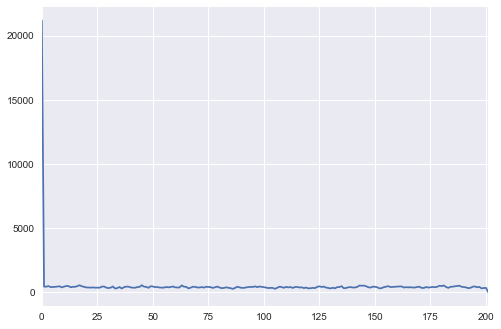

In [243]:
ax = sns.tsplot(data=map(lambda x:x[1], requests_per_second.collect()))

In [244]:
df = pd.DataFrame()

In [245]:
df['ts'] = map(lambda x:x[0], requests_per_second.collect())
df['rps'] = map(lambda x:x[1], requests_per_second.collect())

In [246]:
df['rpsLog'] = np.log(df['rps'])

In [247]:
df['rpsMAp12'] = Series.rolling(df.rpsLog, window = 12).mean()
df['rpsExp12'] = Series.ewm(df.rpsLog, halflife=12).mean()

In [248]:
df["rpsMA12forecast"] = np.exp(df.rpsMAp12)
df["rpsExp12forecast"] = np.exp(df.rpsExp12)

In [249]:
# Root Mean Squared Error (RMSE)
model_MA12_RMSE = RMSE(df.rpsMA12forecast, df.rps)
model_EX12_RMSE = RMSE(df.rpsExp12forecast, df.rps)

print "RMSE with Simple Moving Average :  %s " %(model_MA12_RMSE)
print "RMSE with Simple Exponential Smoothing Model (SES)  :  %s " %(model_EX12_RMSE)

RMSE with Simple Moving Average :  54.0820234859 
RMSE with Simple Exponential Smoothing Model (SES)  :  206.053095769 


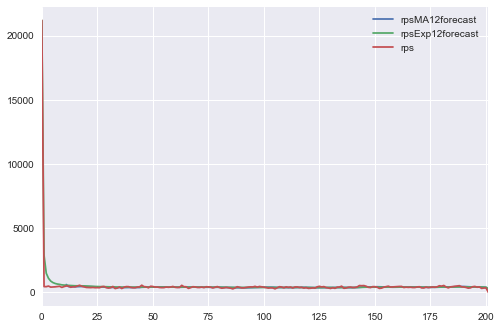

In [250]:
df.plot(kind ="line", y=["rpsMA12forecast", "rpsExp12forecast", "rps"])

#### Predict the session length for a given IP

In [251]:
ip_session_size = (session_data_client_session
                   .map(lambda x:(x[0],[x[1]['timestamp']]))
                   .reduceByKey(lambda x, y: x + y)
                   .map(lambda x: (x[0], (parser.parse(max(x[1])) - parser.parse(min(x[1]))).total_seconds())))

In [252]:
ip_session_size.take(2)

[(('106.51.233.17:5299', '1'), 3.276494),
 (('123.242.248.130:20400', '0'), 1.39116)]

In [253]:
ip_session_size_group_by_ip = (ip_session_size
                               .map(lambda x: (x[0][0], [x[1]]))
                               .reduceByKey(lambda x, y: x + y))

In [254]:
ip_session_size_group_by_ip.take(4)

[('61.3.154.152:11059', [41.858636]),
 ('112.196.37.218:45765', [57.758666]),
 ('180.179.213.94:50530', [0.0]),
 ('180.178.24.61:7447', [7.962457, 41.484762])]

In [255]:
def trainMovingAverageModel(x):
    try:
        df = pd.DataFrame()
        df['sessionLength'] = x
        df['sessionLengthLog'] = np.log(df['sessionLength'])
        df['sessionLengthLogMA12'] = Series.rolling(df.sessionLengthLog, window = 1).mean()
        df["sessionLengthLogMA12forecast"] = np.exp(df.sessionLengthLogMA12)
        model_RMSE = RMSE(df.sessionLengthLogMA12forecast, df.sessionLength)
        return model_RMSE
    except Exception as e:
        return 0.0 

In [256]:
ip_session_RMSE_per_user = (ip_session_size_group_by_ip
                            .map(lambda x: trainMovingAverageModel(x[1]))
                            .filter(lambda x: x != 0)
                            .mean())

In [257]:
print "RMSE error of model to predict session length for each IP : %s" % (ip_session_RMSE_per_user)

RMSE error of model to predict session length for each IP : 8.25811736469e-15


#### Predict the number of unique URL visits by a given IP

In [258]:
ip_url_data = (session_data_client_session
               .map(lambda x:(x[0],[x[1]['request']]))
               .reduceByKey(lambda x, y: x + y)
               .map(lambda x:(x[0], len(set(x[1]))))
               .map(lambda x:(x[0][0], [x[1]]))
               .reduceByKey(lambda x, y: x + y))

In [259]:
ip_url_data.take(10)

[('61.3.154.152:11059', [2]),
 ('112.196.37.218:45765', [4]),
 ('180.179.213.94:50530', [1]),
 ('180.178.24.61:7447', [5, 18]),
 ('182.74.245.226:49730', [2, 2]),
 ('103.231.217.134:60661', [3]),
 ('101.222.160.107:60347', [2]),
 ('106.216.166.183:21490', [8, 6]),
 ('106.186.23.95:36476', [1]),
 ('182.59.91.134:12546', [2])]

In [260]:
ip_url_data_RMSE_mean = (ip_url_data
                         .map(lambda x: trainMovingAverageModel(x[1]))
                         .filter(lambda x: x != 0)
                         .mean())

In [261]:
print "RMSE error of model to predict unique URL visits by a given IP : %s" %(ip_url_data_RMSE_mean)

RMSE error of model to predict unique URL visits by a given IP : 9.78649280791e-16
